In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random

import keras
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization,Activation, Flatten, GlobalAveragePooling2D, SeparableConv2D
from keras.models import Model

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from keras.utils.np_utils import to_categorical
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/project/dataset3/labelTrain3.csv') 
data1 = pd.read_csv('/content/drive/MyDrive/project/dataset3/labelValid3.csv') 
data2 = pd.read_csv('/content/drive/MyDrive/project/dataset3/labelTest3.csv')
data3 = pd.read_csv('/content/drive/MyDrive/project/dataset3/labelTest3final.csv')

In [ ]:
!unzip "/content/drive/MyDrive/project/dataset3/Train3.zip"
!unzip "/content/drive/MyDrive/project/dataset3/Valid3.zip"
!unzip "/content/drive/MyDrive/project/dataset3/Test3.zip"

In [ ]:
y_col = ['Class0', 'Class1']

batch_size = 16

data_path = "/content/Train3" #where you extracted the zip file


# data = data.sample(frac=1)
# data.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(	rescale=1/255.0,	
                               rotation_range=20,	
                               zoom_range=0.05,	
                               width_shift_range=0.1,	
                               height_shift_range=0.1,	
                               shear_range=0.05,	
                               horizontal_flip=True,	
                               vertical_flip=True,	
                               fill_mode="nearest") 
                               
train_generator = train_aug.flow_from_dataframe(
    dataframe=data,
    directory=data_path,
    x_col='Image',
    shuffle=True,
    y_col= y_col,
    class_mode="raw",
    target_size=(500,500),
    batch_size=batch_size)


valid_datagen = ImageDataGenerator(rescale=1/255.0)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=data1,
    directory="/content/Valid3",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)



Found 138 validated image filenames.
Found 32 validated image filenames.


In [ ]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(500, 500, 3))
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

In [ ]:
def brain_model(base_model, img_shape = (500,500,3)):

  input=keras.Input(shape = img_shape, name= "image")

  x1 = Conv2D(64,(22,22),strides=1)(input)
  x1 = MaxPooling2D((4,4))(x1)
  x1 = BatchNormalization()(x1)

  x2 = Conv2D(128,(11,11),strides=1,padding="same")(x1)
  x2 = MaxPooling2D((2,2))(x2)
  x2 = BatchNormalization()(x2)

  x3 = Conv2D(256,(7,7),strides=1,padding="same")(x2)
  x3 = MaxPooling2D((2,2))(x3)
  x3 = BatchNormalization()(x3)

  x4=layers.Flatten()(x3)
  x4=layers.Activation("relu")(x4)
  x5=layers.Dense(1024,"relu")(x4)
  x6=layers.Dense(256,"relu")(x5)
  x=layers.Dense(2,"softmax")(x6)

  model = tf.keras.Model(input, x)
  
  return model

#Create your model using the function above
model = brain_model (base_model, img_shape = (500,500,3))
model.summary()

ResourceExhaustedError: ignored

## 7) Train the Network with  Tuned Parameters

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, batch_size= 16 ,epochs=20, validation_data = valid_generator, callbacks= callback)

Epoch 1/20


ResourceExhaustedError: ignored

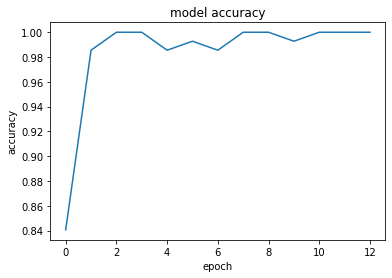

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('Q1_multi.jpg')
plt.show()

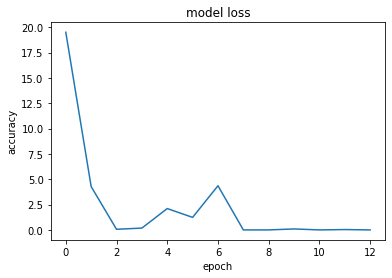

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['8', '16', '32', '128'], loc='upper left')
plt.savefig('Q1_multi.jpg')
plt.show()

In [ ]:
test_aug = ImageDataGenerator(rescale=1/255.0)

test_generator = test_aug.flow_from_dataframe(
    dataframe=data2,
    directory="/content/Test3",
    x_col='Image',
    y_col= y_col,
    shuffle= True,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

Found 30 validated image filenames.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

y_predict = model.predict(test_generator)

y_predict = y_predict.argmax(-1)
accuracy_score(data3['label'],y_predict)
    


0.4666666666666667